# K-MEANS CLUSTERING

### PUNTI DA CHIARIRE:
##### - questione variables da mettere negli assi  --> chat dice che bisogna trovare le variabili che sono correlate tra di loro

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans
from sklearn.cluster import KMeans
#evaluation
from sklearn.metrics import silhouette_score

In [3]:
#df = pd.read_csv("pp_train.csv")
df = pd.read_csv("df_pp_log.csv")
df.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,worstRating,bestRating,totalImages,...,is_War,is_Sci-Fi,is_Talk-Show,is_Adventure,is_Film-Noir,is_Music,is_Western,is_Comedy,is_Drama,fill_runtimeMinutes
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,NaN,NaN,0.000000,6.659294,1,10,0.693147,...,0,0,0,1,0,0,0,0,0,3.713572
1,Looping,6,1982,NaN,NaN,0.000000,2.484907,1,10,0.693147,...,0,0,0,0,0,0,0,0,0,3.367296
2,Idealnaya para,6,1992,NaN,NaN,0.000000,3.663562,1,10,0.693147,...,0,0,0,0,0,0,0,1,0,4.510860
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.000000,2.772589,1,10,3.135494,...,0,0,0,0,0,0,0,0,0,3.465736
4,Seutateueob,8,2020,2020.0,80.0,0.693147,9.662625,1,10,5.852202,...,0,0,0,0,0,0,0,1,1,4.394449


In [4]:
df.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'worstRating', 'bestRating', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType',
       'awardNominationsExcludeWins', 'canHaveEpisodes', 'isRatable',
       'isAdult', 'numRegions', 'userReviewsTotal', 'ratingCount',
       'countryOfOrigin', 'is_Thriller', 'is_Family', 'is_Short', 'is_Sport',
       'is_Biography', 'is_Musical', 'is_Game-Show', 'is_Crime', 'is_Mystery',
       'is_Horror', 'is_Romance', 'is_Animation', 'is_Fantasy', 'is_Action',
       'is_Documentary', 'is_News', 'is_History', 'is_Adult', 'is_Reality-TV',
       'is_War', 'is_Sci-Fi', 'is_Talk-Show', 'is_Adventure', 'is_Film-Noir',
       'is_Music', 'is_Western', 'is_Comedy', 'is_Drama',
       'fill_runtimeMinutes'],
      dtype='object')

#### definizione delle feature da usare per clustering

In [5]:
#features = df[['fill_runtimeMinutes', "numVotes"]]
features = df[["awardWins", "numVotes", "worstRating", "bestRating", "totalImages", "totalVideos", "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", "numRegions", "userReviewsTotal", "fill_runtimeMinutes"]]
X = features.values

#### mapping della variabile target (per noi è titleType) così da confrontarla dopo con gli eventuali cluster/individuare quali cluster contengono un'alta percentuale di quale categoria di titleType

In [6]:
y = np.array(df['titleType'])
y_map = {"tvEpisode": 0, "videoGame": 1, "movie": 2, "tvSeries": 3, "video": 4,
         "tvMiniSeries": 5, "short": 6, "tvMovie": 7, "tvSpecial": 8, "tvShort": 9}

y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map) #target label

### normalizzazione con z-score e minmax

In [7]:
scaler = StandardScaler() 
scaler.fit(X) #x è la numpy matrix of the dataset
X_scal = scaler.transform(X)

In [8]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

### inizializzazione modello

In [9]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94) #inizializziamo algoritmo, fit it per lavorare sull'exact data
#iniziamo con 3 cluster, 10 iterations, random_state: allows to have the same result 

kmeans.fit(X_scal)
#kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=94)

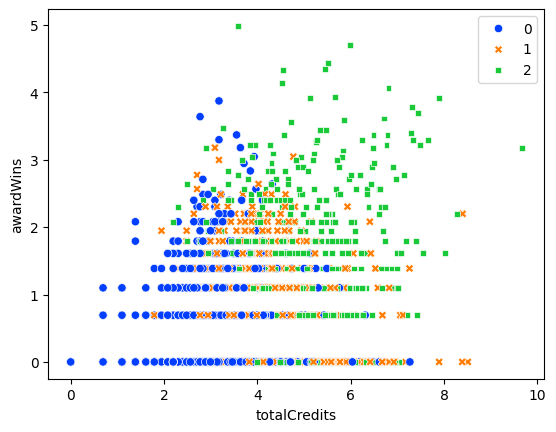

In [10]:
sns.scatterplot(data=df, 
                x="totalCredits",
                y="awardWins",
                hue=kmeans.labels_,
                style=kmeans.labels_, #usiamo labels date da k-means
                palette="bright")
plt.show()

### identificazione dei centroidi

In [11]:
kmeans.cluster_centers_ #coordinates with centroids

array([[-0.16342512, -0.52452199,  0.        ,  0.        , -0.40170024,
        -0.20958079, -0.33122996, -0.40322557, -0.18870383, -0.35604328,
        -0.44835832, -0.52453867, -0.17899245],
       [ 0.05764087,  0.86926269,  0.        ,  0.        ,  0.63586734,
         0.06761131,  0.58899862,  0.48350558,  0.03565721,  0.43665019,
         0.62144443,  0.86931442,  0.31019886],
       [ 1.85263732,  2.4081099 ,  0.        ,  0.        ,  1.99856704,
         2.40849292,  1.31351694,  2.80644028,  2.29897366,  2.42779119,
         2.68716225,  2.40806192,  0.7516301 ]])

In [12]:
centers = scaler.inverse_transform(kmeans.cluster_centers_) #from normalized to input domain
centers

array([[-0.8144465 , -4.4971256 ,  1.        , 10.        , -3.27865561,
        -1.1646044 , -3.20105639, -2.53241621, -0.99791625, -0.57271059,
        -3.87969912, -4.49758438, -1.43313901],
       [ 0.28725944, 12.21399779,  1.        , 10.        ,  5.18991473,
         0.37570442,  5.69217168,  3.03660641,  0.18856486,  2.24559059,
         5.37743429, 12.21504696,  2.48366944],
       [ 9.23281562, 30.66438409,  1.        , 10.        , 16.31219584,
        13.38358104, 12.69402621, 17.62555589, 12.15758663,  9.32478987,
        23.25234199, 30.66499691,  6.0180774 ]])

In [13]:
df['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})

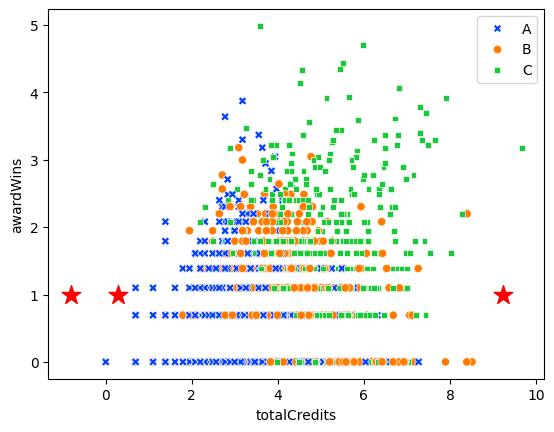

In [14]:
sns.scatterplot(data=df, 
                x="totalCredits", 
                y="awardWins", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright", 
                hue_order=["A", "B", "C"]
               )
plt.legend()
#qui è giusto che centers sia :,1 se in quello di fedele dice [:,2]?
plt.scatter(centers[:,0], centers[:,2], c='red', marker='*', s=200) #plotting the centroids
plt.show()

### conronto con target variable

In [15]:
y_mapped

0        0
1        1
2        2
3        3
4        3
        ..
16426    2
16427    2
16428    2
16429    2
16430    6
Name: 0, Length: 16431, dtype: int64

In [16]:
y_mapped.groupby(df['kmeans_labels']).value_counts(normalize=True)

kmeans_labels  0
A              0    0.302299
B              0    0.296591
C              0    0.015294
A              1    0.017261
B              1    0.012727
C              1    0.011765
               2    0.781176
B              2    0.457273
A              2    0.255702
C              3    0.134118
B              3    0.082045
A              3    0.080494
               4    0.062070
B              4    0.020227
C              4    0.010588
B              5    0.015000
A              5    0.013237
C              5    0.011765
A              6    0.199624
B              6    0.052955
C              6    0.010588
B              7    0.055227
A              7    0.054110
C              7    0.023529
A              8    0.012074
B              8    0.006818
C              8    0.001176
A              9    0.003130
B              9    0.001136
Name: proportion, dtype: float64

### metrics

In [17]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))

SSE 105168.24743847546
Silhouette 0.32547052898072876


In [18]:
%%time
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

CPU times: total: 5min 6s
Wall time: 51.2 s


In [19]:
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sil_list.append(silhouette_score(X_minmax, kmeans.labels_))

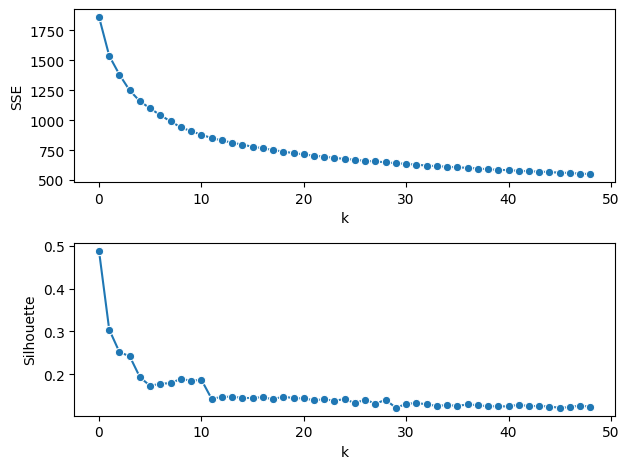

In [20]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout()